In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet("data/processed/df_agg.parquet", engine="pyarrow")

In [2]:
df.head()

,customer_id,spending_mean,spending_min,spending_max,deposit_mean,deposit_min,deposit_max,mean_spending_per_day,mean_deposit_per_day,emb_mean_0,...,spending_std,deposit_median,deposit_std,first_day,last_day,active_days_span,unique_tr_desc,unique_time_cat,mean_spending_deposit_ratio,gender
0,6815,-17981.854409,-224591.58,-22.46,451092.183333,224.59,2470507.35,1.410256,1.000000,-0.032929,...,29652.262014,50533.105,990028.956041,10,454,444,6,4,0.039863,NaN
1,22899,-38847.708675,-868607.92,-88.04,85572.397794,88.04,875907.15,1.765957,1.307692,0.149913,...,102071.385485,33688.740,141569.144017,1,456,455,21,4,0.453975,1.0
2,27914,-44564.559474,-462658.65,-1122.96,11710.848571,1122.96,89836.63,1.357143,1.129032,-0.167673,...,121931.651195,5614.790,20519.704519,13,451,438,7,4,3.805408,1.0
3,28753,-296121.687828,-3244539.76,-2245.92,914148.179400,7860.71,3099363.77,1.648649,1.428571,0.193729,...,602533.653083,700905.395,805859.113805,0,452,452,15,4,0.323932,0.0
4,31385,-10033.152135,-364366.15,-16.84,54405.845652,2245.92,199886.50,2.326531,1.210526,0.068887,...,27343.958680,41549.440,53114.569478,0,436,436,17,4,0.184413,0.0


In [3]:
df.shape

(15000, 1275)

In [4]:
df.dtypes

customer_id                      int64
spending_mean                  float64
spending_min                   float64
spending_max                   float64
deposit_mean                   float64
                                ...   
active_days_span                 int64
unique_tr_desc                   int64
unique_time_cat                  int64
mean_spending_deposit_ratio    float64
gender                         float64
Length: 1275, dtype: object

In [6]:
# Получаем булеву серию, где True — колонка с числовым типом
numeric_mask = df.dtypes.apply(
    lambda dt: np.issubdtype(dt, np.integer) or np.issubdtype(dt, np.floating)
)

# Проверяем, что все True
if numeric_mask.all():
    print("Все колонки имеют числовой тип (int или float).")
else:
    print("Есть колонки с НЕ числовым типом:")
    print(df.columns[~numeric_mask].tolist())

Есть колонки с НЕ числовым типом:
['top1_tr', 'top2_tr', 'top1_time']


In [9]:
df[["top1_tr", "top2_tr", "top1_time"]].head()

,top1_tr,top2_tr,top1_time
0,Оплата услуги. Банкоматы СБ РФ,Выдача наличных в АТМ Сбербанк России,рабочее время
1,Выдача наличных в АТМ Сбербанк России,Оплата услуги. Банкоматы СБ РФ,рабочее время
2,Оплата услуги. Банкоматы СБ РФ,Выдача наличных в АТМ Сбербанк России,рабочее время
3,Покупка. POS ТУ СБ РФ,Покупка. POS ТУ Россия,рабочее время
4,Оплата услуги. Банкоматы СБ РФ,Покупка. POS ТУ СБ РФ,рабочее время


In [10]:
# Получаем все уникальные категории из двух колонок
unique_cats = pd.unique(df[["top1_tr", "top2_tr"]].values.ravel())

# Создаём маппинг категория -> число
cat_to_int = {cat: i for i, cat in enumerate(unique_cats)}

# Применяем кодирование
df["top1_tr_enc"] = df["top1_tr"].map(cat_to_int)
df["top2_tr_enc"] = df["top2_tr"].map(cat_to_int)

In [33]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["top1_time_enc"] = encoder.fit_transform(df["top1_time"])

In [ ]:
# df = df.drop("top_1_time_enc", axis=1)

In [36]:
df = df.drop(columns=["top1_tr", "top2_tr", "top1_time"], axis=1)

In [38]:
df[["top1_tr_enc", "top2_tr_enc", "top1_time_enc"]].head()

,top1_tr_enc,top2_tr_enc,top1_time_enc
0,0,1,2
1,1,0,2
2,0,1,2
3,2,3,2
4,0,2,2


In [11]:
import json

# cat_to_int — словарь категория (строка) -> число
with open("cat_to_int.json", "w", encoding="utf-8") as f:
    json.dump(cat_to_int, f, ensure_ascii=False, indent=2)

In [39]:
test_df = df[df["gender"].isna()].copy()
X_test, y_test = test_df.drop("gender", axis=1).copy(), test_df["gender"].copy()

In [40]:
df_for_ml = df[df["gender"].isna() == False].copy()
X, y = df_for_ml.drop("gender", axis=1).copy(), df_for_ml["gender"].copy()

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
y_train

14478    0.0
4447     1.0
1586     0.0
7842     1.0
12987    1.0
        ... 
10165    0.0
9193     1.0
9553     1.0
1513     0.0
12932    0.0
Name: gender, Length: 6720, dtype: float64

In [21]:
y_valid

46       1.0
9350     1.0
8692     1.0
5849     1.0
8410     0.0
        ... 
558      1.0
4302     0.0
10826    1.0
10498    0.0
3725     0.0
Name: gender, Length: 1680, dtype: float64

In [22]:
X_train

,customer_id,spending_mean,spending_min,spending_max,deposit_mean,deposit_min,deposit_max,mean_spending_per_day,mean_deposit_per_day,emb_mean_0,...,deposit_median,deposit_std,first_day,last_day,active_days_span,unique_tr_desc,unique_time_cat,mean_spending_deposit_ratio,top1_tr_enc,top2_tr_enc
14478,96637590,-62375.503071,-3368873.66,-224.59,960830.840833,22459.16,5390197.85,2.295082,1.142857,0.243690,...,370576.10,1.414394e+06,0,454,454,19,4,0.064918,0,3
4447,30099451,-3417.194928,-44918.32,-22.46,12433.690000,3612.33,22459.16,1.254545,1.500000,-0.137088,...,11229.58,9.480937e+03,85,449,364,8,4,0.274834,0,1
1586,10890438,-57069.257311,-786070.52,-673.77,232077.963333,67377.47,561478.94,1.341772,1.000000,0.191449,...,134754.95,1.775552e+05,2,455,453,9,4,0.245906,1,2
7842,52900428,-25062.166790,-130263.11,-22.46,NaN,NaN,NaN,1.421053,NaN,0.370480,...,NaN,NaN,217,453,236,4,4,0.000000,2,1
12987,86650713,-33005.117469,-624364.58,-224.59,119029.792667,1909.03,624364.58,2.382353,1.250000,0.234682,...,67377.47,1.456034e+05,12,456,444,14,4,0.277285,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,68277946,-33134.323279,-7164471.31,-224.59,19764.060000,8983.66,33688.74,1.547739,1.250000,-0.063668,...,22459.16,9.968428e+03,1,452,451,6,4,1.676494,0,2
9193,61974549,-20048.126105,-786070.52,-42.67,NaN,NaN,NaN,1.670635,NaN,0.461933,...,NaN,NaN,6,453,447,5,4,0.000000,2,1
9553,64172822,-56820.751846,-853447.99,-224.59,187261.334286,5064.32,909595.89,1.989796,1.000000,0.144030,...,134856.46,1.993322e+05,0,456,456,16,4,0.303430,3,2
1513,10376412,-24627.276148,-777086.86,-0.67,85875.630463,0.22,1679945.00,1.962441,1.186813,0.391330,...,56147.89,1.658861e+05,0,456,456,15,4,0.286778,2,1


In [23]:
X_valid

,customer_id,spending_mean,spending_min,spending_max,deposit_mean,deposit_min,deposit_max,mean_spending_per_day,mean_deposit_per_day,emb_mean_0,...,deposit_median,deposit_std,first_day,last_day,active_days_span,unique_tr_desc,unique_time_cat,mean_spending_deposit_ratio,top1_tr_enc,top2_tr_enc
46,312146,-31056.310256,-673774.73,-336.89,2.712567e+04,2245.92,235821.16,1.508287,1.000000,-0.003174,...,13475.490,4.433151e+04,0,455,455,10,4,1.144905,0,1
9350,62926046,-79379.015082,-1572141.04,-449.18,2.245916e+04,22459.16,22459.16,1.703704,1.000000,0.353425,...,22459.160,0.000000e+00,2,456,454,8,4,3.534372,1,2
8692,58760290,-122485.592037,-449183.15,-11229.58,NaN,NaN,NaN,1.038462,NaN,0.294860,...,NaN,NaN,6,446,440,2,3,0.000000,1,11
5849,39718714,-76364.339368,-898366.31,-449.18,1.624920e+06,76361.14,3144282.08,2.111111,1.000000,0.499318,...,1639518.515,1.391107e+06,18,453,435,7,3,0.046996,2,1
8410,56698049,-56046.414466,-390789.34,-224.59,3.113448e+04,224.59,157214.10,1.287500,1.517241,0.557463,...,22459.160,3.482690e+04,7,456,449,10,4,1.800140,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,4095398,-82342.529357,-786070.52,-8.53,1.520260e+05,1122.96,900612.22,1.794872,1.388889,0.003952,...,38742.050,2.298557e+05,2,451,449,15,4,0.541634,0,1
4302,29184546,-12466.785027,-141492.69,-179.67,3.812985e+04,1122.96,145984.53,1.550847,1.155844,0.108930,...,22459.160,3.749042e+04,4,454,450,12,4,0.326956,0,4
10826,72230568,-71891.924215,-2245915.77,-224.59,1.324298e+05,1459.85,336887.37,2.244068,1.142857,0.288367,...,112295.790,8.376912e+04,1,456,455,20,4,0.542868,2,3
10498,70267911,-18302.163818,-224591.58,-855.69,1.437611e+05,6737.75,482871.89,1.527778,1.022727,0.260727,...,78607.050,1.311888e+05,4,451,447,9,4,0.127310,2,3


In [43]:
from xgboost import __version__

print(__version__)

3.1.1


In [52]:
from xgboost import XGBClassifier

model = XGBClassifier(
    tree_method="hist",
    device="cuda",
    predictor="gpu_predictor",
    use_label_encoder=False,
    eval_metric=["logloss", "error", "auc", "aucpr"],  # примеры метрик
    random_state=42,
    base_score=0.5,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
)

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Доступ к результатам обучения (метрики по итерациям)
results = model.evals_result()

[0]	validation_0-logloss:0.65947	validation_0-error:0.23274	validation_0-auc:0.83989	validation_0-aucpr:0.81697	validation_1-logloss:0.66978	validation_1-error:0.31012	validation_1-auc:0.75053	validation_1-aucpr:0.69784
[1]	validation_0-logloss:0.63123	validation_0-error:0.22262	validation_0-auc:0.86207	validation_0-aucpr:0.84139	validation_1-logloss:0.64784	validation_1-error:0.28988	validation_1-auc:0.78150	validation_1-aucpr:0.73146
[2]	validation_0-logloss:0.60494	validation_0-error:0.20223	validation_0-auc:0.88379	validation_0-aucpr:0.86741	validation_1-logloss:0.62953	validation_1-error:0.27798	validation_1-auc:0.80076	validation_1-aucpr:0.75249
[3]	validation_0-logloss:0.58211	validation_0-error:0.19524	validation_0-auc:0.89355	validation_0-aucpr:0.87900	validation_1-logloss:0.61430	validation_1-error:0.28274	validation_1-auc:0.80817	validation_1-aucpr:0.76992
[4]	validation_0-logloss:0.56241	validation_0-error:0.18973	validation_0-auc:0.89816	validation_0-aucpr:0.88573	validati

/mnt/data/elbrus/test_case_postgraduate/test_case/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:37:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[9]	validation_0-logloss:0.48551	validation_0-error:0.16339	validation_0-auc:0.92232	validation_0-aucpr:0.91480	validation_1-logloss:0.55758	validation_1-error:0.25952	validation_1-auc:0.81957	validation_1-aucpr:0.78813
[10]	validation_0-logloss:0.47138	validation_0-error:0.15744	validation_0-auc:0.92856	validation_0-aucpr:0.92129	validation_1-logloss:0.55106	validation_1-error:0.25536	validation_1-auc:0.82179	validation_1-aucpr:0.78759
[11]	validation_0-logloss:0.45987	validation_0-error:0.15089	validation_0-auc:0.93192	validation_0-aucpr:0.92562	validation_1-logloss:0.54545	validation_1-error:0.26310	validation_1-auc:0.82323	validation_1-aucpr:0.79096
[12]	validation_0-logloss:0.44781	validation_0-error:0.14613	validation_0-auc:0.93668	validation_0-aucpr:0.93064	validation_1-logloss:0.54055	validation_1-error:0.25952	validation_1-auc:0.82431	validation_1-aucpr:0.79297
[13]	validation_0-logloss:0.43819	validation_0-error:0.14420	validation_0-auc:0.93945	validation_0-aucpr:0.93340	vali

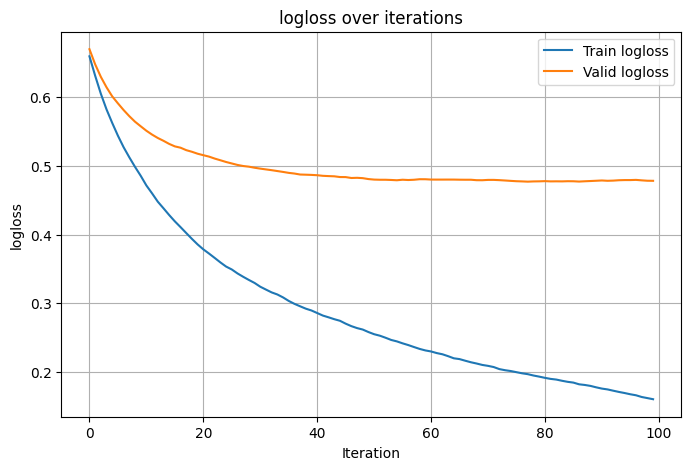

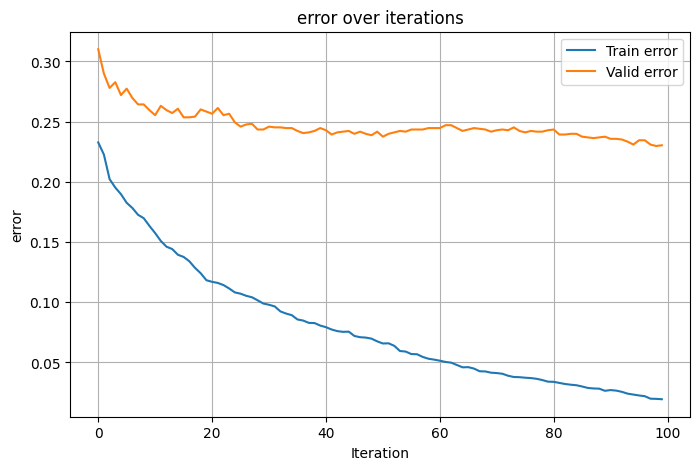

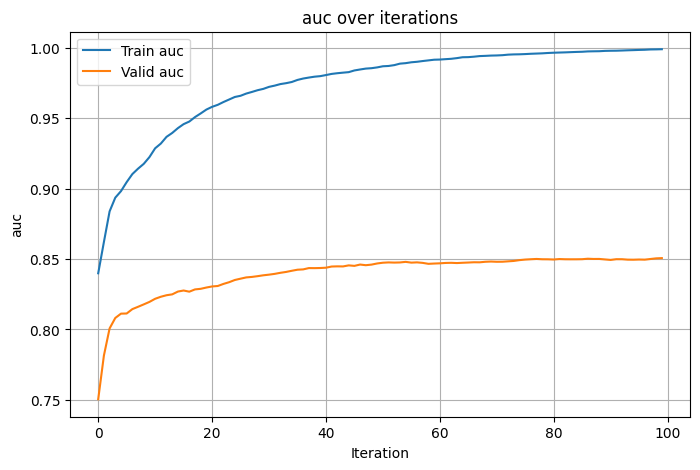

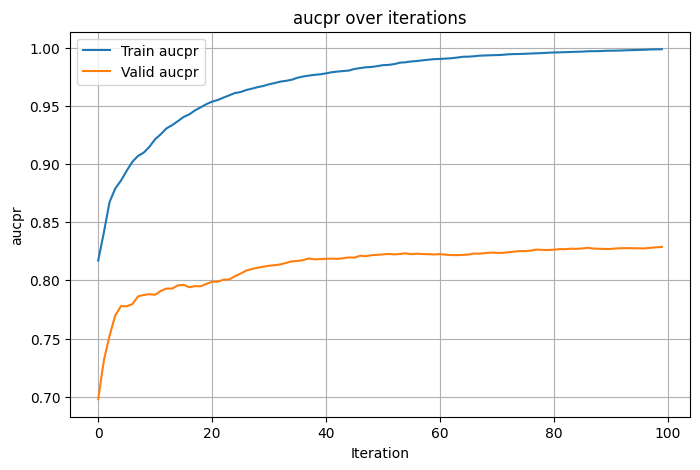

In [53]:
import matplotlib.pyplot as plt


# Функция для построения графиков метрик
def plot_metrics(results, metrics=None):
    if metrics is None:
        metrics = results["validation_0"].keys()  # все метрики

    for metric in metrics:
        plt.figure(figsize=(8, 5))
        train_metric = results["validation_0"][metric]
        valid_metric = results["validation_1"][metric]

        plt.plot(train_metric, label="Train " + metric)
        plt.plot(valid_metric, label="Valid " + metric)
        plt.xlabel("Iteration")
        plt.ylabel(metric)
        plt.title(f"{metric} over iterations")
        plt.legend()
        plt.grid(True)
        plt.show()


# Вызов функции с нужными метриками
plot_metrics(results)

Accuracy: 0.7696
Precision: 0.7585
Recall: 0.7258
F1-score: 0.7418
ROC-AUC: 0.8506


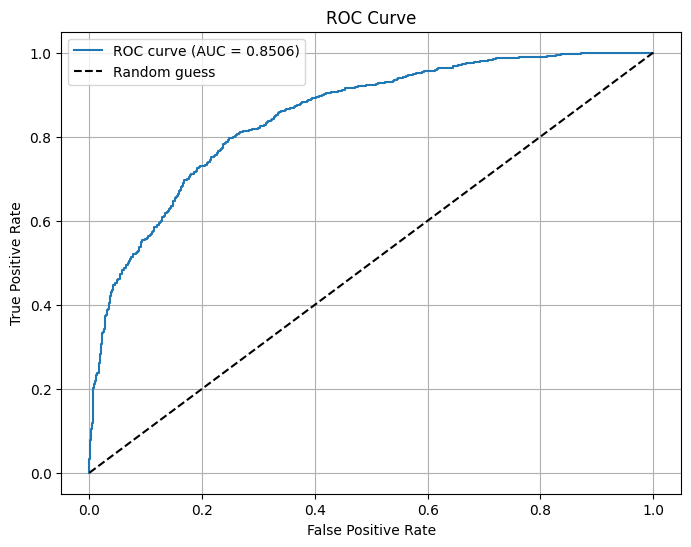

''

In [54]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

# Предсказания классов и вероятностей для валидации
y_pred = model.predict(X_valid)
y_probs = model.predict_proba(X_valid)[:, 1]  # вероятности положительного класса

# Метрики
acc = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred)
rec = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_probs)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_valid, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
;

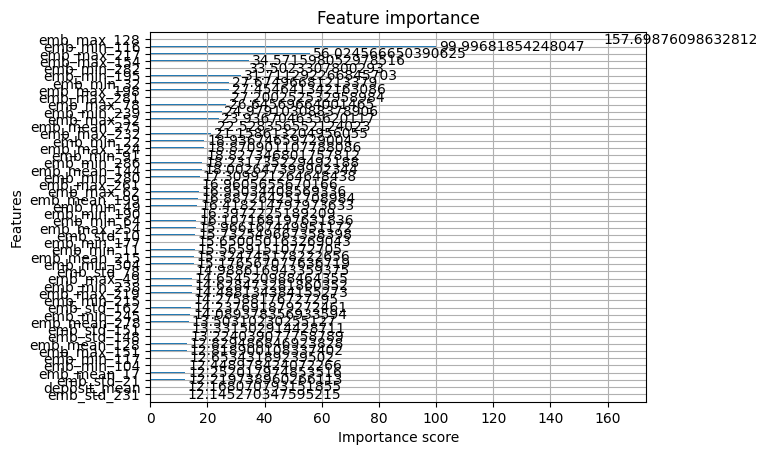

In [55]:
import xgboost as xgb

fig = xgb.plot_importance(
    model, max_num_features=50, importance_type="gain"
)  # 'gain', 'weight', 'cover'

plt.show()

In [57]:
print(model.get_booster().attributes())

{}


In [64]:
booster = model.get_booster()
bs = booster.attr("base_score")
print(bs)

None


In [65]:
print(booster.attributes())

{}


In [66]:
model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cuda',
 'eval_metric': ['logloss', 'error', 'auc', 'aucpr'],
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'predictor': 'gpu_predictor',
 'use_label_encoder': False}

In [67]:
base_score = model.get_xgb_params().get("base_score", 0.5)
print(base_score)  # Should print 0.5

0.5


In [72]:
import shap

# Assume model is your trained XGBClassifier or XGBRegressor
booster = model.get_booster()

# Get the model configuration as a JSON string
config_str = booster.save_config()
config = json.loads(config_str)

# Fix base_score if it has brackets like '[5E-1]'
base_score_raw = config["learner"]["learner_model_param"]["base_score"]
type(base_score_raw)

str

In [73]:
# If the base_score is a string and has brackets, remove them
if isinstance(base_score_raw, str) and base_score_raw.startswith("["):
    clean_base_score = base_score_raw.strip("[]")
    # You may also want to convert scientific notation to float
    try:
        clean_base_score = float(clean_base_score)
    except Exception:
        clean_base_score = 0.5  # fallback, or use your trained default

    config["learner"]["learner_model_param"]["base_score"] = str(clean_base_score)

    # Overwrite config in the booster with the fixed base_score
    booster.load_config(json.dumps(config))

In [75]:
new_base_score = config["learner"]["learner_model_param"]["base_score"]
new_base_score

'0.5'

In [78]:
new_config = json.loads(booster.save_config())
new_config

{'learner': {'generic_param': {'device': 'cuda:0',
   'fail_on_invalid_gpu_id': '0',
   'n_jobs': '0',
   'nthread': '0',
   'random_state': '42',
   'seed': '42',
   'seed_per_iteration': '0',
   'validate_parameters': '1'},
  'gradient_booster': {'gbtree_model_param': {'num_parallel_tree': '1',
    'num_trees': '100'},
   'gbtree_train_param': {'process_type': 'default',
    'tree_method': 'hist',
    'updater': 'grow_gpu_hist',
    'updater_seq': 'grow_gpu_hist'},
   'name': 'gbtree',
   'specified_updater': False,
   'tree_train_param': {'alpha': '0',
    'cache_opt': '1',
    'colsample_bylevel': '1',
    'colsample_bynode': '1',
    'colsample_bytree': '1',
    'eta': '0.100000001',
    'gamma': '0',
    'grow_policy': 'depthwise',
    'interaction_constraints': '',
    'lambda': '1',
    'learning_rate': '0.100000001',
    'max_bin': '256',
    'max_cat_threshold': '64',
    'max_cat_to_onehot': '4',
    'max_delta_step': '0',
    'max_depth': '6',
    'max_leaves': '0',
    'mi

In [77]:
# Now use SHAP as usual
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_valid)  # Use your validation/test data

# Optionally, summarize and plot
shap.summary_plot(shap_values, X_valid)

ValueError: could not convert string to float: '[5E-1]'